In [ ]:
# Uninstall any existing TensorFlow
!pip uninstall tensorflow -y

# Install TensorFlow 2.17
!pip install tensorflow==2.17.0

# Install Keras, Keras Tuner, and other required libraries
!pip install keras keras-tuner scikit-learn matplotlib scikit-image imblearn

# Verify the installation
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer

print("TensorFlow version:", tf.__version__)
print("Keras Tuner version:", kt.__version__)



Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
TensorFlow version: 2.17.0
Keras Tuner version: 1.4.7


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization ,Activation, GlobalAveragePooling2D,LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2,l1_l2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
from google.colab import drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load images and labels
def load_images_and_labels(folder_path, image_size=(224, 224)):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            image = imread(file_path)
            if image is not None:
                image = resize(image, image_size, anti_aliasing=True)
                # Normalize the image
                image =normalize_image(image)

                images.append(image)
                label = file.rsplit('_', 1)[0]
                labels.append(label)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return np.array(images), np.array(labels)


In [ ]:
def normalize_image(image):
    # Normalize the image to scale pixel values to [0, 1]
    return image / 255.0


In [ ]:
def compute_mean_std(images):
    mean, variance = tf.nn.moments(images, axes=[0, 1, 2])
    stddev = tf.sqrt(variance) + 1e-7  # Add small constant to avoid division by zero
    return mean, stddev


In [ ]:
def standardize_images(images, mean, stddev):
    return (images - mean) / stddev


In [ ]:
# Load dataset
folder_path ='/content/drive/MyDrive/Colab Notebooks/Model/Data/Mendeley/classificacao_binaria/images_new'

images, labels = load_images_and_labels(folder_path)

# Check the shape of images and labels
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)


Shape of images: (7919, 224, 224, 3)
Shape of labels: (7919,)


In [ ]:
# Compute mean and stddev from the dataset
mean, stddev = compute_mean_std(images)

# Convert tensors to NumPy arrays
mean_np = mean.numpy()
stddev_np = stddev.numpy()

print("Mean:", mean)
print("Stddev:", stddev)

# Save to files
np.save('mean.npy', mean_np)
np.save('stddev.npy', stddev_np)

# Standardize images using computed mean and stddev
standardized_images = standardize_images(images, mean_np, stddev_np)


Mean: tf.Tensor([0.00308388 0.00245429 0.00299549], shape=(3,), dtype=float64)
Stddev: tf.Tensor([0.00050341 0.00070119 0.00044395], shape=(3,), dtype=float64)


In [ ]:
mean_np = np.load('mean.npy')
stddev_np = np.load('stddev.npy')
standardized_images = standardize_images(images, mean_np, stddev_np)


In [ ]:
# Split the dataset
img_train, img_test, lbl_train, lbl_test = train_test_split(
    standardized_images, labels, test_size=0.25, random_state=42
)

# Check the shape of images and labels
print("Shape of images (train):", img_train.shape)
print("Shape of images (test):", img_test.shape)
print("Shape of labels (train):", lbl_train.shape)
print("Shape of labels (test):", lbl_test.shape)

Shape of images (train): (5939, 224, 224, 3)
Shape of images (test): (1980, 224, 224, 3)
Shape of labels (train): (5939,)
Shape of labels (test): (1980,)


# Data Preprocessing

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
lbl_train_encoded = label_encoder.fit_transform(lbl_train)
lbl_test_encoded = label_encoder.transform(lbl_test)
lbl_encoded = label_encoder.transform(labels)
num_classes = len(label_encoder.classes_)

In [ ]:
# Count the number of samples in each class before augmentation
unique, counts = np.unique(lbl_train_encoded, return_counts=True)
class_distribution_before = dict(zip(unique, counts))

# Assign counts to specific variables based on the class labels
count_class_0 = counts[unique == 0][0] if 0 in unique else 0
count_class_1 = counts[unique == 1][0] if 1 in unique else 0

print("Class distribution before augmentation:", dict(zip(unique, counts)))
print(f"Number of samples in Class 0: {count_class_0}")
print(f"Number of samples in Class 1: {count_class_1}")


Class distribution before augmentation: {0: 1869, 1: 4070}
Number of samples in Class 0: 1869
Number of samples in Class 1: 4070


In [ ]:
# Data augmentation for minority class

mindatagen = ImageDataGenerator(
    rotation_range=20,            # Increase rotation range
    width_shift_range=0.02,        # Increase width shift range
    height_shift_range=0.02,       # Increase height shift range
    zoom_range=0.2,               # Increase zoom range
    horizontal_flip=True,         # Keep horizontal flip
    brightness_range=[0.8, 1.2],  # Vary brightness
    fill_mode='nearest'
)

batch_size = 32

minority_images = img_train[lbl_train_encoded == 0]  # Minority class
minority_labels = lbl_train_encoded[lbl_train_encoded == 0]

# Create a data generator for the minority class
minority_generator = mindatagen.flow(
    minority_images,
    minority_labels,
    batch_size=batch_size
)

# Calculate the number of samples needed
additional_samples_needed = int(0.05 * count_class_1)  # Example for 5% more
n_samples_needed = additional_samples_needed + (count_class_1 - count_class_0)

# Augmenting and appending data
augmented_images = []
augmented_labels = []
for _ in range(n_samples_needed // batch_size + 1):  # Generate more samples
    imgs, lbls = next(minority_generator)
    augmented_images.append(imgs)
    augmented_labels.append(lbls)
    if len(augmented_images) * batch_size >= n_samples_needed:
        break  # Stop if enough samples are generated

augmented_images = np.concatenate(augmented_images)[:n_samples_needed]  # Slice to required number
augmented_labels = np.concatenate(augmented_labels)[:n_samples_needed]

# Append to the original dataset
img_train_augmented = np.concatenate([img_train, augmented_images])
lbl_train_encoded_augmented = np.concatenate([lbl_train_encoded, augmented_labels])

Class distribution after augmentation: {0: 4273, 1: 4070}


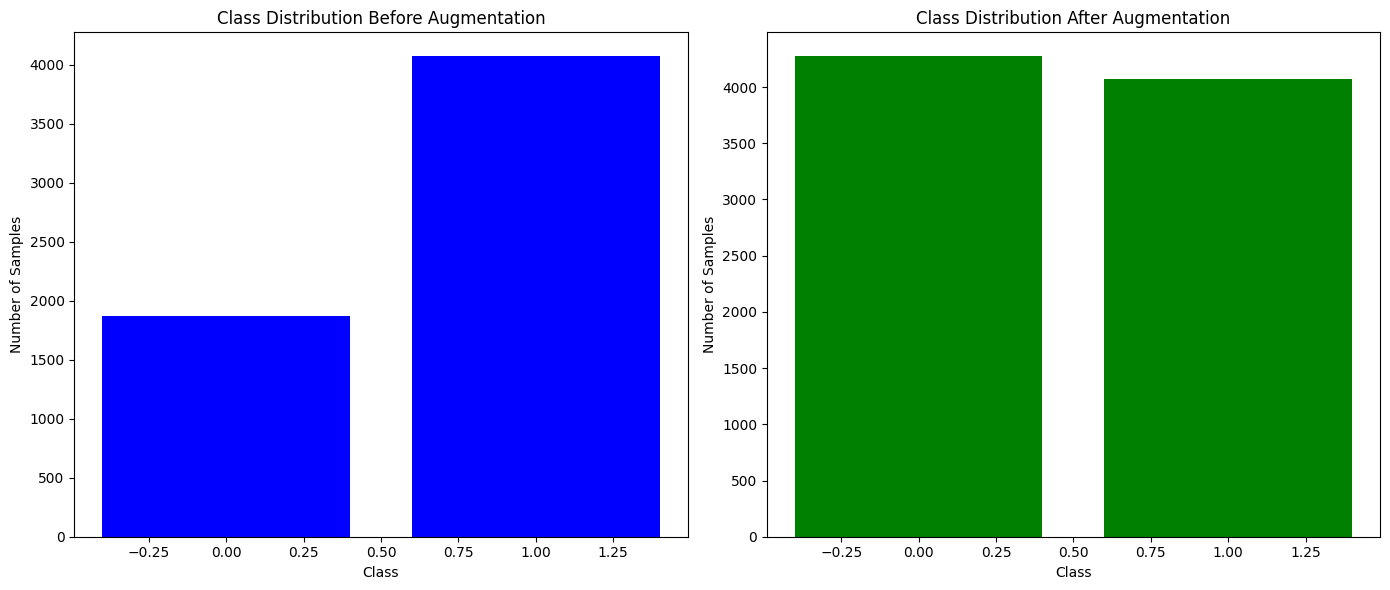

In [ ]:

# Count the number of samples in each class after augmentation
unique_aug, counts_aug = np.unique(lbl_train_encoded_augmented, return_counts=True)
class_distribution_after = dict(zip(unique_aug, counts_aug))
print("Class distribution after augmentation:", class_distribution_after)

# Plotting the class distribution before and after augmentation
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot before augmentation
ax[0].bar(class_distribution_before.keys(), class_distribution_before.values(), color='blue')
ax[0].set_title('Class Distribution Before Augmentation')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Samples')

# Plot after augmentation
ax[1].bar(class_distribution_after.keys(), class_distribution_after.values(), color='green')
ax[1].set_title('Class Distribution After Augmentation')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

In [ ]:
# Data augmentation for whole dataset
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)
batch_size = 32

# Create the data generator for training data
train_generator = datagen.flow(
    img_train_augmented,
    lbl_train_encoded_augmented,
    batch_size=batch_size,
    shuffle=True  # Shuffle training data
)

# For validation data
val_datagen = ImageDataGenerator()

# Create the data generator for validation data
val_generator = val_datagen.flow(
    img_test,
    lbl_test_encoded,
    batch_size=batch_size,
    shuffle=False  # No shuffling for validation data
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Assume you have classes 0 and 1
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(lbl_encoded),
    y=lbl_encoded
)

# Convert to dictionary
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


# DCNN Model

In [ ]:
# Define the updated VGG-9-like model
VGG9_Dcnn_Model = Sequential([
    # Block 1
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3),
           kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),  # Dropout after convolution
    MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 2
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),  # Dropout after convolution
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),  # Dropout after convolution
    MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 3
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),  # Dropout after convolution
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),  # Dropout after convolution
    MaxPooling2D((2, 2), strides=(2, 2)),



    # Fully Connected Layers
    GlobalAveragePooling2D(),

    Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
    Dropout(0.4),  # Dropout in dense layer
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
    Dropout(0.4),  # Dropout in dense layer
    Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-6, l2=1e-4)),
    Dropout(0.4),  # Dropout in dense layer
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Define the learning rate and optimizer
optimal_lr = 1e-4  # Starting learning rate
optimizer = AdamW(learning_rate=optimal_lr, weight_decay=1e-4)#

# Compile the model
VGG9_Dcnn_Model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
VGG9_Dcnn_Model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │              

 Total params: 1,277,057 (4.87 MB)

 Trainable params: 1,275,393 (4.87 MB)

 Non-trainable params: 1,664 (6.50 KB)

# Hyperparameter Tunning

In [ ]:
#Build model for hyperparameter tunning with keras tuner
def build_model(hp):
    model = Sequential()

    # Block 1
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=(224, 224, 3),
        kernel_regularizer=l1_l2(
            l1=1e-7,
            l2=1e-4)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('conv1_dropout', min_value=0.1, max_value=0.6, step=0.1)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    for i in range(2):  # Two Conv2D layers
        model.add(Conv2D(128,
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=l1_l2(
                l1=1e-7,
                l2=1e-4)
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float(f'conv2_dropout_{i}', min_value=0.1, max_value=0.6, step=0.1)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    for i in range(2):  # Two Conv2D layers
        model.add(Conv2D(256,
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=l1_l2(
                l1=1e-7,
                l2=1e-4)
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float(f'conv3_dropout_{i}', min_value=0.1, max_value=0.6, step=0.1)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(GlobalAveragePooling2D())

    for i in range(3):  # Three Dense layers
        model.add(Dense(
            units=hp.Int(f'fc_units_{i}', min_value=64, max_value=512, step=64),
            activation='relu',
            kernel_regularizer=l1_l2(
                l1=1e-7,
                l2=1e-4)
        ))
        model.add(Dropout(rate=hp.Float(f'fc_dropout_{i}', min_value=0.3, max_value=0.7, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate and optimizer with weight decay
    lr = hp.Float('learning_rate', min_value=1e-9, max_value=1e-3, sampling='log')
    wd = hp.Float('weight_decay', min_value=1e-6, max_value=1e-4, sampling='log')
    optimizer = AdamW(learning_rate=lr, weight_decay=wd)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model
# Calculate steps per epoch and validation steps
steps_per_epoch = len(img_train_augmented) // batch_size
validation_steps = len(img_test) // batch_size

# Set up callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-12),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
]

# RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,  # Specify exact number of trials
    directory='randomsearch_tuning',
    project_name='vgg9_like_model'
)

# Perform the search
tuner.search(train_generator,
             steps_per_epoch=steps_per_epoch,
             validation_data=val_generator,
             validation_steps=validation_steps,
             epochs=20,
             class_weight=class_weights_dict,
             callbacks=callbacks)


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters found:", best_hps.values)

# Build the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Best hyperparameters found: {'conv1_filters': 32, 'conv1_dropout': 0.1, 'conv2_dropout_0': 0.1, 'conv2_dropout_1': 0.2, 'conv3_dropout_0': 0.2, 'conv3_dropout_1': 0.1, 'fc_units_0': 384, 'fc_dropout_0': 0.3, 'fc_units_1': 448, 'fc_dropout_1': 0.5, 'fc_units_2': 512, 'fc_dropout_2': 0.6000000000000001, 'learning_rate': 6.668164718461625e-05, 'weight_decay': 1.5185965795089264e-05}


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 256)                 │              

 Total params: 1,575,489 (6.01 MB)

 Trainable params: 1,573,889 (6.00 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [ ]:
# Save the model
best_model.save('/content/drive/MyDrive/Colab Notebooks/Model/best_model.keras')


In [ ]:
#Code for the new VGG9 like DCNN Model with best hyperparameters

# Best hyperparameters
best_hyperparameters = {
    'conv1_filters': 32,
    'conv1_dropout': 0.1,
    'conv2_dropout_0': 0.1,
    'conv2_dropout_1': 0.2,
    'conv3_dropout_0': 0.2,
    'conv3_dropout_1': 0.1,
    'fc_units_0': 384,
    'fc_dropout_0': 0.3,
    'fc_units_1': 448,
    'fc_dropout_1': 0.5,
    'fc_units_2': 512,
    'fc_dropout_2': 0.6,
    'learning_rate': 6.668164718461625e-05,
    'weight_decay': 1.5185965795089264e-05
}

#Bulid Model
def build_final_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(
        filters=best_hyperparameters['conv1_filters'],
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=(224, 224, 3),
        kernel_regularizer=l1_l2(
            l1=1e-7,
            l2=1e-4)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=best_hyperparameters['conv1_dropout']))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    for i in range(2):  # Two Conv2D layers
        model.add(Conv2D(128,
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=l1_l2(
                l1=1e-7,
                l2=1e-4)
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters[f'conv2_dropout_{i}']))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    for i in range(2):  # Two Conv2D layers
        model.add(Conv2D(256,
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
            kernel_regularizer=l1_l2(
                l1=1e-7,
                l2=1e-4)
        ))
        model.add(BatchNormalization())
        model.add(Dropout(rate=best_hyperparameters[f'conv3_dropout_{i}']))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully Connected Layers
    model.add(GlobalAveragePooling2D())

    for i in range(3):  # Three Dense layers
        model.add(Dense(
            units=best_hyperparameters[f'fc_units_{i}'],
            activation='relu',
            kernel_regularizer=l1_l2(
                l1=1e-7,
                l2=1e-4)
        ))
        model.add(Dropout(rate=best_hyperparameters[f'fc_dropout_{i}']))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Learning rate and optimizer with weight decay
    lr = best_hyperparameters['learning_rate']
    wd = best_hyperparameters['weight_decay']
    optimizer = AdamW(learning_rate=lr, weight_decay=wd)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create and compile the final model with the best hyperparameters
model = build_final_model()

# Model summary to verify the architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │              

 Total params: 1,575,489 (6.01 MB)

 Trainable params: 1,573,889 (6.00 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [ ]:
# Calculate steps per epoch and validation steps
steps_per_epoch = len(img_train_augmented) // batch_size
validation_steps = len(img_test) // batch_size

# Set up callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-12),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
       validation_data= val_generator,
    validation_steps=validation_steps,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=2)


Epoch 1/20
260/260 - 99s - 380ms/step - accuracy: 0.8633 - loss: 0.4735 - val_accuracy: 0.8899 - val_loss: 0.4472 - learning_rate: 4.1676e-06
Epoch 2/20
260/260 - 0s - 201us/step - accuracy: 0.7500 - loss: 0.6212 - val_accuracy: 0.7500 - val_loss: 0.9770 - learning_rate: 4.1676e-06
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


260/260 - 98s - 376ms/step - accuracy: 0.8668 - loss: 0.4750 - val_accuracy: 0.8904 - val_loss: 0.4361 - learning_rate: 4.1676e-06
Epoch 4/20
260/260 - 0s - 533us/step - accuracy: 0.8438 - loss: 0.4541 - val_accuracy: 0.7857 - val_loss: 0.9571 - learning_rate: 4.1676e-06
Epoch 5/20
260/260 - 98s - 377ms/step - accuracy: 0.8703 - loss: 0.4702 - val_accuracy: 0.8914 - val_loss: 0.4411 - learning_rate: 4.1676e-06
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 2.0838015188928694e-06.
260/260 - 0s - 209us/step - accuracy: 0.8438 - loss: 0.4726 - val_accuracy: 0.7500 - val_loss: 0.9892 - learning_rate: 4.1676e-06
Epoch 7/20
260/260 - 100s - 385ms/step - accuracy: 0.8682 - loss: 0.4626 - val_accuracy: 0.8909 - val_loss: 0.4463 - learning_rate: 2.0838e-06
Epoch 8/20
260/260 - 0s - 195us/step - accuracy: 0.8750 - loss: 0.3815 - val_accuracy: 0.7500 - val_loss: 1.0234 - learning_rate: 2.0838e-06
Epoch 9/20

Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0419007594464347

# Evaluation

In [ ]:
# Evaluate the model on the test dataset
evaluation = model.evaluate(val_generator, steps=validation_steps)
test_loss, test_accuracy = evaluation


print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")



61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8887 - loss: 0.4356
Test Accuracy: 89.04%
Test Loss: 0.4361


In [ ]:
# Get all true labels from val_generator
true_labels = []
val_generator.reset()  # Reset generator to start from the first batch again
for _ in range(validation_steps):
    _, labels = next(val_generator)
    true_labels.extend(labels)

# Predict on the full validation set
y_pred = model.predict(val_generator, steps=validation_steps)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

# Ensure both true_labels and y_pred_classes have the same length
true_labels = np.array(true_labels).flatten()

# Generate classification report
print(classification_report(true_labels, y_pred_classes))


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       594
           1       0.91      0.94      0.92      1358

    accuracy                           0.89      1952
   macro avg       0.88      0.86      0.87      1952
weighted avg       0.89      0.89      0.89      1952



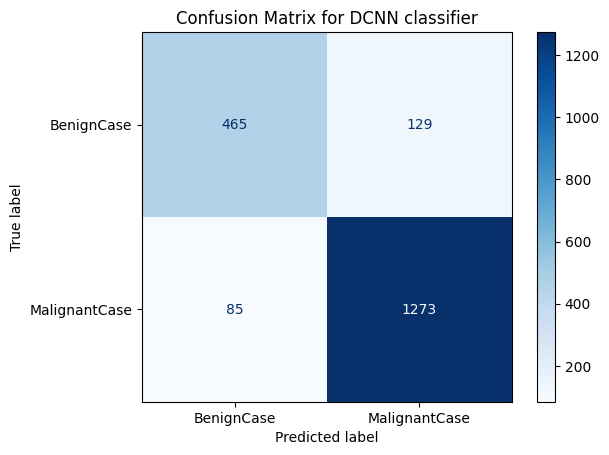

In [ ]:
# Compute confusion matrix
cm_Dcnn = confusion_matrix(true_labels, y_pred_classes)

# Display confusion matrix
disp_Dcnn = ConfusionMatrixDisplay(confusion_matrix=cm_Dcnn, display_labels=label_encoder.classes_)
disp_Dcnn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for DCNN classifier')
plt.show()

In [ ]:
true_labels = np.array(true_labels)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, y_pred_classes)
auc = roc_auc_score(true_labels, y_pred_classes)

print(f"ROC AUC Score: {auc}")

ROC AUC Score: 0.8601181178500767
